In [1]:
!pip install transformers

In [38]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer

In [39]:
data = pd.read_csv('amazon_reviews_us_Video_Games_v1_00.tsv',sep='\t',on_bad_lines='skip')

In [40]:
data = data.sort_values(by=['review_date'], ascending=False)
df = data[['star_rating','review_body']]
# drop any rows w/ missing values
df = df.dropna()

In [41]:
# Function to map stars to sentiment
def map_sentiment(stars_received):
    if stars_received <= 2:
        return 0
    elif stars_received == 3:
        return 1
    else:
        return 2
    
# Mapping stars to sentiment into three categories
df['star_rating_v1'] = [ map_sentiment(x) for x in df['star_rating']]

In [42]:
# discover the actual counts
df.star_rating_v1.value_counts()

2    1340582
0     286178
1     153449
Name: star_rating_v1, dtype: int64

In [43]:
# set sample size to labels w/ minimum count
sample_size = 3000
df_equal_overall = pd.DataFrame()
for i in df.star_rating_v1.unique():
    X = df[df.star_rating_v1 == i].sample(sample_size)
    df_equal_overall = pd.concat([df_equal_overall, X])

In [44]:
df_equal_overall.head()

,star_rating,review_body,star_rating_v1
920388,5,Our oldest spent an entire year convincing me ...,2
1106817,5,This game is simply put AWESOME. Mechanics wor...,2
1010280,5,Daughter loves it!!! My daughter loves it!!! D...,2
235103,5,"This is the greatest game ever made, for rhyth...",2
637556,5,The perfect item for collectors and legend of ...,2


In [45]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [46]:
token = tokenizer.encode_plus(
    df_equal_overall['review_body'].iloc[0],
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf')

In [47]:
X_input_ids = np.zeros((len(df_equal_overall),256))
X_attn_masks = np.zeros((len(df_equal_overall),256))

In [48]:
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['review_body'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [49]:
X_input_ids, X_attn_masks = generate_training_data(df_equal_overall, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [50]:
labels = np.zeros((len(df_equal_overall), 3))
labels.shape

(9000, 3)

In [51]:
labels[np.arange(len(df_equal_overall)), df_equal_overall['star_rating_v1'].values] = 1 # one-hot encoded target tensor

In [52]:
labels

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [53]:
# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(3,), dtype=tf.float64, name=None))>

In [54]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [55]:
dataset = dataset.map(SentimentDatasetMapFunction) # converting to required format for tensorflow dataset 

In [56]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.float64, name=None))>

In [57]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [58]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 3), dtype=tf.float64, name=None))>

In [59]:
p = 0.8
train_size = int((len(df_equal_overall)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.

In [60]:
train_size

449

In [61]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [62]:
from transformers import TFBertModel

In [63]:
model = TFBertModel.from_pretrained('bert-base-cased') # bert base model with pretrained weights

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [64]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(3, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

sentiment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
sentiment_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                         

In [65]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [66]:
sentiment_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [67]:
hist = sentiment_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1
)

449/449 [==============================] - 8875s 20s/step - loss: 0.7568 - accuracy: 0.6489 - val_loss: 0.5625 - val_accuracy: 0.7705


In [68]:
sentiment_model.save('sentiment_model')

INFO:tensorflow:Assets written to: sentiment_model/assets


INFO:tensorflow:Assets written to: sentiment_model/assets


In [69]:
sentiment_model = tf.keras.models.load_model('sentiment_model')

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=['Negative', 'Neutral', 'Positive']):
    probs = model.predict(processed_data)[0]
    return classes[np.argmax(probs)]

In [75]:
heldout_data=df[~df.isin(df_equal_overall)].dropna()
heldout_data = heldout_data[['star_rating_v1','review_body']]
heldout_data = heldout_data[:2000]
heldout_data.star_rating_v1.value_counts()

2.0    1627
0.0     258
1.0     115
Name: star_rating_v1, dtype: int64

In [76]:
for i, row in heldout_data.iterrows():
    processed_data = prepare_data(row["review_body"], tokenizer)
    heldout_data.at[i,"prediction"] = make_prediction(sentiment_model, processed_data=processed_data)

heldout_data

1/1 [==============================] - 0s 451ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 0s 336ms/step


1/1 [==============================] - 0s 347ms/step


1/1 [==============================] - 0s 406ms/step


1/1 [==============================] - 0s 336ms/step


1/1 [==============================] - 0s 366ms/step


,star_rating_v1,review_body,prediction
0,2.0,"Used this for Elite Dangerous on my mac, an am...",Positive
827,2.0,good,Positive
834,2.0,This was a fun game. I've played and beaten it...,Positive
833,2.0,Great game but needs optimization on PC<br /><...,Positive
832,2.0,"I bought this controller for my PC, so my kids...",Positive
...,...,...,...
1327,2.0,"Gift, just want my son wanted.",Positive
1328,0.0,yeah I bought mine refurbished what thateabs i...,Positive
1329,2.0,Just what my kid wanted!,Positive
1330,2.0,"Great controller, i just wish microsoft would ...",Positive


In [77]:
heldout_data.prediction.value_counts()

Positive    1526
Negative     311
Neutral      163
Name: prediction, dtype: int64

In [79]:
heldout_data.to_csv('heldout_data.csv')

In [80]:
df_equal_overall.to_csv('df_equal_overall_train.csv')

In [1]:
#building confusion matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
heldout_data = pd.read_csv('heldout_data.csv',on_bad_lines='skip')

In [4]:
# Function to map prediction to stars
def map_sentiment(prediction_received):
    if prediction_received == 'Positive':
        return 2
    elif prediction_received == 'Neutral':
        return 1
    else:
        return 0
    
# Mapping stars to sentiment into three categories
heldout_data['star_rating_prediction'] = [ map_sentiment(x) for x in heldout_data['prediction']]

In [5]:
def plot_confusion_matrix(cm, classes, ax, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues, set_y_label = True):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax.imshow(cm, interpolation='nearest', cmap=cmap)

    # Add the labels
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set(yticks=[0,1,2], 
            xticks=[0, 1, 2], 
           yticklabels=classes, 
           xticklabels=classes)
    #ax.yaxis.set_major_locator(matplotlib.ticker.IndexLocator(base=1, offset=0.5))
    if title:
        ax.set_title(title)
    if(set_y_label):
      ax.set_ylabel('Ground truth label')
    ax.set_xlabel('Predicted label')

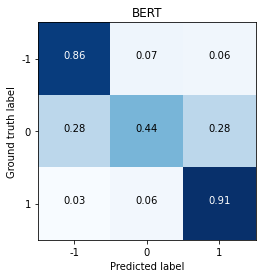

In [6]:
fig, ax = plt.subplots(ncols=1, nrows=1)

plot_confusion_matrix(confusion_matrix(heldout_data['star_rating_v1'], heldout_data['star_rating_prediction']), ("-1","0", "1"), 
                      ax, normalize=True, title = 'BERT')